<a href="https://colab.research.google.com/github/skywalker0803r/works/blob/master/end_to_end(modelA%EF%BC%8BB%EF%BC%8BC)V3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import joblib
from torch import nn
from tqdm import tqdm_notebook as tqdm
#!pip install autorch
import autorch

In [2]:
c = joblib.load('/content/drive/MyDrive/台塑輕油案子/data/phase2/dataset/col_names.pkl')
c.keys()

dict_keys(['xna', 'xle', 'xhc', 'xhe', 'fna', 'fle', 'fhc', 'fhe', 'yld', 'Tray_temp', 'duty', 'Rate_m3', 'Rate_ton', 'sle', 'shc', 'she', 'case'])

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
df = pd.read_csv('/content/drive/MyDrive/台塑輕油案子/data/phase2/dataset/train.csv',index_col=0)
df = df.dropna(axis=0).astype('float32')
df.head(3)

,Naphtha Properties_Oxygen_wt%,Naphtha Properties_Methane_wt%,Naphtha Properties_Ethane_wt%,Naphtha Properties_Propane_wt%,Naphtha Properties_n-Butane_wt%,Naphtha Properties_i-Pentane_wt%,Naphtha Properties_n-Pentane_wt%,Naphtha Properties_tr2-Pentene_wt%,Naphtha Properties_Cyclopentane_wt%,Naphtha Properties_3-Methylpentane_wt%,Naphtha Properties_tr2-Hexene_wt%,Naphtha Properties_n-Hexane_wt%,Naphtha Properties_Methylcyclopentane_wt%,"Naphtha Properties_2,2-Dimethylpentane_wt%",Naphtha Properties_Benzene_wt%,Naphtha Properties_Cyclohexane_wt%,"Naphtha Properties_2,2,3-Trimethylbutane_wt%",Naphtha Properties_4-Methyl-1-hexene_wt%,Naphtha Properties_2-Methylhexane_wt%,"Naphtha Properties_t-1,3-Dimethylcyclopentane_wt%",Naphtha Properties_n-Heptane_wt%,Naphtha Properties_H2O_wt%,Naphtha Properties_Methylcyclohexane_wt%,Naphtha Properties_Ethylcyclopentane_wt%,"Naphtha Properties_2,3-Dimethyl-1-hexene_wt%",Naphtha Properties_Toluene_wt%,Naphtha Properties_2-Methylheptane_wt%,Naphtha Properties_n-Octane_wt%,Naphtha Properties_Ethylcyclohexane_wt%,Naphtha Properties_EthylBenzene_wt%,Naphtha Properties_P-Xylene_wt%,Naphtha Properties_M-Xylene_wt%,Naphtha Properties_O-Xylene_wt%,Naphtha Properties_2-Methyloctane_wt%,Naphtha Properties_1-Nonene_wt%,Naphtha Properties_n-Nonane_wt%,Naphtha Properties_i-Propylbenzene_wt%,"Naphtha Properties_1-trans-3,5-Trimethylcyclohexane_wt%",Naphtha Properties_n-Propylcyclohexane_wt%,Naphtha Properties_n-Propylbenzene_wt%,...,Individual Component to Heavy End Split Factor_2-Methylhexane_Ratio,"Individual Component to Heavy End Split Factor_t-1,3-Dimethylcyclopentane_Ratio",Individual Component to Heavy End Split Factor_n-Heptane_Ratio,Individual Component to Heavy End Split Factor_H2O_Ratio,Individual Component to Heavy End Split Factor_Methylcyclohexane_Ratio,Individual Component to Heavy End Split Factor_Ethylcyclopentane_Ratio,"Individual Component to Heavy End Split Factor_2,3-Dimethyl-1-hexene_Ratio",Individual Component to Heavy End Split Factor_Toluene_Ratio,Individual Component to Heavy End Split Factor_2-Methylheptane_Ratio,Individual Component to Heavy End Split Factor_n-Octane_Ratio,Individual Component to Heavy End Split Factor_Ethylcyclohexane_Ratio,Individual Component to Heavy End Split Factor_EthylBenzene_Ratio,Individual Component to Heavy End Split Factor_P-Xylene_Ratio,Individual Component to Heavy End Split Factor_M-Xylene_Ratio,Individual Component to Heavy End Split Factor_O-Xylene_Ratio,Individual Component to Heavy End Split Factor_2-Methyloctane_Ratio,Individual Component to Heavy End Split Factor_1-Nonene_Ratio,Individual Component to Heavy End Split Factor_n-Nonane_Ratio,Individual Component to Heavy End Split Factor_i-Propylbenzene_Ratio,"Individual Component to Heavy End Split Factor_1-trans-3,5-Trimethylcyclohexane_Ratio",Individual Component to Heavy End Split Factor_n-Propylcyclohexane_Ratio,Individual Component to Heavy End Split Factor_n-Propylbenzene_Ratio,"Individual Component to Heavy End Split Factor_1,3,5-Trimethylbenzene_Ratio",Individual Component to Heavy End Split Factor_1-Methyl-2-ethylbenzene_Ratio,"Individual Component to Heavy End Split Factor_1,2,3-Trimethylbenzene_Ratio","Individual Component to Heavy End Split Factor_2,4-Dimethyloctane_Ratio","Individual Component to Heavy End Split Factor_2,2,3,3-Tetramethylhexane_Ratio",Individual Component to Heavy End Split Factor_3-Methylnonane_Ratio,Individual Component to Heavy End Split Factor_tert-Butylcyclohexane_Ratio,Individual Component to Heavy End Split Factor_n-Decane_Ratio,"Individual Component to Heavy End Split Factor_1,2-Diethylbenzene_Ratio",Individual Component to Heavy End Split Factor_n-Undecane_Ratio,Individual Component to Heavy End Split Factor_n-Pentylbenzene_Ratio,Individual Component to Heavy End Split Factor_n-Dodecane_Ratio,Individual Component to Heavy End Split Factor_n-Hexylbenzene_Ratio,Individual Component to Heavy End Split Factor_n-Tridecane_Ratio,Case Conditions_C7+ in Light End 

In [5]:
# X
X = df[c['case']+c['xna']]
print('X.shape',X.shape)

# modelA的Y
Y1 = df[c['sle']+c['shc']+c['she']]
print('Y1.shape',Y1.shape)

duty = df[c['duty']]
density = pd.DataFrame(df[c['Rate_ton']].values/df[c['Rate_m3']].values,
                       columns=['NA_density','LE_density','HC_density','HE_density'],
                       index=df.index)
# modelB的Y
Y2 = duty.join(density)
print('Y2.shape',Y2.shape)

# modelC的Y
Y3 = df[c['Tray_temp']+c['fna']+c['yld']]
print('Y3.shape',Y3.shape)

# (modelA + modelB + modelC)的Y
Y = Y1.join(Y2).join(Y3)
print('Y.shape',Y.shape)

X.shape (16498, 58)
Y1.shape (16498, 162)
Y2.shape (16498, 7)
Y3.shape (16498, 8)
Y.shape (16498, 177)


In [6]:
wt = df[c['xle']+c['xhc']+c['xhe']]
df = X.join(Y).join(wt)
x_col = X.columns.tolist()
y_col = Y.columns.tolist()

In [7]:
normalize_idx_list = []
for i in range(54):
  normalize_idx_list.append([y_col.index(c['sle'][i]),
                             y_col.index(c['shc'][i]),
                             y_col.index(c['she'][i])])
for idx in tqdm(normalize_idx_list):
  assert np.allclose(df[y_col].iloc[:,idx].sum(axis=1),1) # 因為分離係數要確保質量平衡

  0%|          | 1/300 [00:01<05:20,  1.07s/it]

epoch:0 train_loss:0.0065 valid_loss:0.0017


 17%|█▋        | 51/300 [00:50<04:06,  1.01it/s]

epoch:50 train_loss:0.0002 valid_loss:0.0002


 34%|███▎      | 101/300 [01:40<03:18,  1.00it/s]

epoch:100 train_loss:0.0001 valid_loss:0.0001


 50%|█████     | 151/300 [02:30<02:27,  1.01it/s]

epoch:150 train_loss:0.0001 valid_loss:0.0001


 67%|██████▋   | 201/300 [03:19<01:39,  1.01s/it]

epoch:200 train_loss:0.0001 valid_loss:0.0001


 84%|████████▎ | 251/300 [04:09<00:49,  1.00s/it]

epoch:250 train_loss:0.0000 valid_loss:0.0001


100%|██████████| 300/300 [04:58<00:00,  1.01it/s]


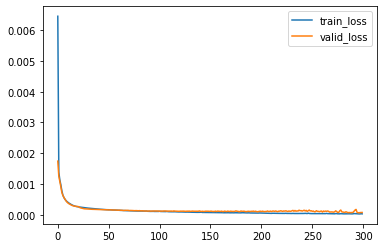

In [8]:
model = autorch.utils.PartBulider(df,x_col,y_col,normalize_idx_list=normalize_idx_list,device='cuda:0') # 使用 gpu train 快一些
model.loss_fn = nn.SmoothL1Loss() # SmoothL1增加穩健性
model.train()

In [9]:
res = model.test(e=0.01)
res

,R2,MSE,MAPE
Individual Component to Light End Split Factor_Oxygen_Ratio,0,3.27904e-08,0.0120536
Individual Component to Light End Split Factor_Methane_Ratio,0,3.16878e-08,0.0123712
Individual Component to Light End Split Factor_Ethane_Ratio,0,3.24606e-08,0.0125514
Individual Component to Light End Split Factor_Propane_Ratio,0.987749,2.89678e-07,0.0372205
Individual Component to Light End Split Factor_n-Butane_Ratio,0.986947,1.51368e-06,0.0869678
...,...,...,...
Yield Summary_Reflux Rate_m3/hr,0.978933,3.909,2.7121
Yield Summary_Light End Prod. Rate_m3/hr,0.997813,0.0734057,3.06995
Yield Summary_Heart Cut Prod. Rate_m3/hr,0.999036,0.017929,0.0999818
Yield Summary_Heavy End Prod. Rate_m3/hr,0.948841,0.0935958,2.20352


# 分離係數 to 重量百分比 (sp2wt)

In [10]:
from autorch.function import sp2wt
x_test = model.data['X_test']
y_pred = model.predict(x_test)
xna = x_test[c['xna']]
xle = sp2wt(xna.values,y_pred[c['sle']].values)
xhc = sp2wt(xna.values,y_pred[c['shc']].values)
xhe = sp2wt(xna.values,y_pred[c['she']].values)
wt_pred = np.hstack((xle,xhc,xhe))
wt_pred = pd.DataFrame(wt_pred,index=x_test.index,columns=c['xle']+c['xhc']+c['xhe'])
wt_pred.head()

,Light End Product Properties_Oxygen_wt%,Light End Product Properties_Methane_wt%,Light End Product Properties_Ethane_wt%,Light End Product Properties_Propane_wt%,Light End Product Properties_n-Butane_wt%,Light End Product Properties_i-Pentane_wt%,Light End Product Properties_n-Pentane_wt%,Light End Product Properties_tr2-Pentene_wt%,Light End Product Properties_Cyclopentane_wt%,Light End Product Properties_3-Methylpentane_wt%,Light End Product Properties_tr2-Hexene_wt%,Light End Product Properties_n-Hexane_wt%,Light End Product Properties_Methylcyclopentane_wt%,"Light End Product Properties_2,2-Dimethylpentane_wt%",Light End Product Properties_Benzene_wt%,Light End Product Properties_Cyclohexane_wt%,"Light End Product Properties_2,2,3-Trimethylbutane_wt%",Light End Product Properties_4-Methyl-1-hexene_wt%,Light End Product Properties_2-Methylhexane_wt%,"Light End Product Properties_t-1,3-Dimethylcyclopentane_wt%",Light End Product Properties_n-Heptane_wt%,Light End Product Properties_H2O_wt%,Light End Product Properties_Methylcyclohexane_wt%,Light End Product Properties_Ethylcyclopentane_wt%,"Light End Product Properties_2,3-Dimethyl-1-hexene_wt%",Light End Product Properties_Toluene_wt%,Light End Product Properties_2-Methylheptane_wt%,Light End Product Properties_n-Octane_wt%,Light End Product Properties_Ethylcyclohexane_wt%,Light End Product Properties_EthylBenzene_wt%,Light End Product Properties_P-Xylene_wt%,Light End Product Properties_M-Xylene_wt%,Light End Product Properties_O-Xylene_wt%,Light End Product Properties_2-Methyloctane_wt%,Light End Product Properties_1-Nonene_wt%,Light End Product Properties_n-Nonane_wt%,Light End Product Properties_i-Propylbenzene_wt%,"Light End Product Properties_1-trans-3,5-Trimethylcyclohexane_wt%",Light End Product Properties_n-Propylcyclohexane_wt%,Light End Product Properties_n-Propylbenzene_wt%,...,Heavy End Product Properties_Benzene_wt%,Heavy End Product Properties_Cyclohexane_wt%,"Heavy End Product Properties_2,2,3-Trimethylbutane_wt%",Heavy End Product Properties_4-Methyl-1-hexene_wt%,Heavy End Product Properties_2-Methylhexane_wt%,"Heavy End Product Properties_t-1,3-Dimethylcyclopentane_wt%",Heavy End Product Properties_n-Heptane_wt%,Heavy End Product Properties_H2O_wt%,Heavy End Product Properties_Methylcyclohexane_wt%,Heavy End Product Properties_Ethylcyclopentane_wt%,"Heavy End Product Properties_2,3-Dimethyl-1-hexene_wt%",Heavy End Product Properties_Toluene_wt%,Heavy End Product Properties_2-Methylheptane_wt%,Heavy End Product Properties_n-Octane_wt%,Heavy End Product Properties_Ethylcyclohexane_wt%,Heavy End Product Properties_EthylBenzene_wt%,Heavy End Product Properties_P-Xylene_wt%,Heavy End Product Properties_M-Xylene_wt%,Heavy End Product Properties_O-Xylene_wt%,Heavy End Product Properties_2-Methyloctane_wt%,Heavy End Product Properties_1-Nonene_wt%,Heavy End Product Properties_n-Nonane_wt%,Heavy End Product Properties_i-Propylbenzene_wt%,"Heavy End Product Properties_1-trans-3,5-Trimethylcyclohexane_wt%",Heavy End Product Properties_n-Propylcyclohexane_wt%,Heavy End Product Properties_n-Propylbenzene_wt%,"Heavy End Product Properties_1,3,5-Trimethylbenzene_wt%",Heavy End Product Properties_1-Methyl-2-ethylbenzene_wt%,"Heavy End Product Properties_1,2,3-Trimethylbenzene_wt%","Heavy End Product Properties_2,4-Dimethyloctane_wt%","Heavy End Product Properties_2,2,3,3-Tetramethylhexane_wt%",Heavy End Product Properties_3-Methylnonane_wt%,Heavy End Product Properties_tert-Butylcyclohexane_wt%,Heavy End Product Properties_n-Decane_wt%,"Heavy End Product Properties_1,2-Diethylbenzene_wt%",Heavy End Product Properties_n-Undecane_wt%,Heavy End Product Properties_n-Pentylbenzene_wt%,Heavy End Product Properties_n-Dodecane_wt%,Heavy End Product Properties_n-Hexylbenzene_wt%,Heavy End Product Properties_n-Tridecane_wt%
113-26,0.0,0.0,0.0,0.285993,0.563433,4.582638,8.080523,0.110874,0.981717,25.113955,0.443199,31.707426,14.744162,1.924951,3.478630,4.895092,1.526167,0.010857,1.

In [11]:
wt_real = df.loc[x_test.index,c['xle']+c['xhc']+c['xhe']]
wt_real.head()

,Light End Product Properties_Oxygen_wt%,Light End Product Properties_Methane_wt%,Light End Product Properties_Ethane_wt%,Light End Product Properties_Propane_wt%,Light End Product Properties_n-Butane_wt%,Light End Product Properties_i-Pentane_wt%,Light End Product Properties_n-Pentane_wt%,Light End Product Properties_tr2-Pentene_wt%,Light End Product Properties_Cyclopentane_wt%,Light End Product Properties_3-Methylpentane_wt%,Light End Product Properties_tr2-Hexene_wt%,Light End Product Properties_n-Hexane_wt%,Light End Product Properties_Methylcyclopentane_wt%,"Light End Product Properties_2,2-Dimethylpentane_wt%",Light End Product Properties_Benzene_wt%,Light End Product Properties_Cyclohexane_wt%,"Light End Product Properties_2,2,3-Trimethylbutane_wt%",Light End Product Properties_4-Methyl-1-hexene_wt%,Light End Product Properties_2-Methylhexane_wt%,"Light End Product Properties_t-1,3-Dimethylcyclopentane_wt%",Light End Product Properties_n-Heptane_wt%,Light End Product Properties_H2O_wt%,Light End Product Properties_Methylcyclohexane_wt%,Light End Product Properties_Ethylcyclopentane_wt%,"Light End Product Properties_2,3-Dimethyl-1-hexene_wt%",Light End Product Properties_Toluene_wt%,Light End Product Properties_2-Methylheptane_wt%,Light End Product Properties_n-Octane_wt%,Light End Product Properties_Ethylcyclohexane_wt%,Light End Product Properties_EthylBenzene_wt%,Light End Product Properties_P-Xylene_wt%,Light End Product Properties_M-Xylene_wt%,Light End Product Properties_O-Xylene_wt%,Light End Product Properties_2-Methyloctane_wt%,Light End Product Properties_1-Nonene_wt%,Light End Product Properties_n-Nonane_wt%,Light End Product Properties_i-Propylbenzene_wt%,"Light End Product Properties_1-trans-3,5-Trimethylcyclohexane_wt%",Light End Product Properties_n-Propylcyclohexane_wt%,Light End Product Properties_n-Propylbenzene_wt%,...,Heavy End Product Properties_Benzene_wt%,Heavy End Product Properties_Cyclohexane_wt%,"Heavy End Product Properties_2,2,3-Trimethylbutane_wt%",Heavy End Product Properties_4-Methyl-1-hexene_wt%,Heavy End Product Properties_2-Methylhexane_wt%,"Heavy End Product Properties_t-1,3-Dimethylcyclopentane_wt%",Heavy End Product Properties_n-Heptane_wt%,Heavy End Product Properties_H2O_wt%,Heavy End Product Properties_Methylcyclohexane_wt%,Heavy End Product Properties_Ethylcyclopentane_wt%,"Heavy End Product Properties_2,3-Dimethyl-1-hexene_wt%",Heavy End Product Properties_Toluene_wt%,Heavy End Product Properties_2-Methylheptane_wt%,Heavy End Product Properties_n-Octane_wt%,Heavy End Product Properties_Ethylcyclohexane_wt%,Heavy End Product Properties_EthylBenzene_wt%,Heavy End Product Properties_P-Xylene_wt%,Heavy End Product Properties_M-Xylene_wt%,Heavy End Product Properties_O-Xylene_wt%,Heavy End Product Properties_2-Methyloctane_wt%,Heavy End Product Properties_1-Nonene_wt%,Heavy End Product Properties_n-Nonane_wt%,Heavy End Product Properties_i-Propylbenzene_wt%,"Heavy End Product Properties_1-trans-3,5-Trimethylcyclohexane_wt%",Heavy End Product Properties_n-Propylcyclohexane_wt%,Heavy End Product Properties_n-Propylbenzene_wt%,"Heavy End Product Properties_1,3,5-Trimethylbenzene_wt%",Heavy End Product Properties_1-Methyl-2-ethylbenzene_wt%,"Heavy End Product Properties_1,2,3-Trimethylbenzene_wt%","Heavy End Product Properties_2,4-Dimethyloctane_wt%","Heavy End Product Properties_2,2,3,3-Tetramethylhexane_wt%",Heavy End Product Properties_3-Methylnonane_wt%,Heavy End Product Properties_tert-Butylcyclohexane_wt%,Heavy End Product Properties_n-Decane_wt%,"Heavy End Product Properties_1,2-Diethylbenzene_wt%",Heavy End Product Properties_n-Undecane_wt%,Heavy End Product Properties_n-Pentylbenzene_wt%,Heavy End Product Properties_n-Dodecane_wt%,Heavy End Product Properties_n-Hexylbenzene_wt%,Heavy End Product Properties_n-Tridecane_wt%
113-26,0.0,0.0,0.0,0.285454,0.562451,4.566056,8.055749,0.110786,0.984430,25.044712,0.444264,31.534103,14.879225,1.940832,3.471760,5.061251,1.550156,0.010683,1.

In [12]:
pd.set_option('display.max_rows',200)
res = model.show_metrics(wt_real,wt_pred,e=1e-2)
res

,R2,MSE,MAPE
Light End Product Properties_Oxygen_wt%,1,0,NaN
Light End Product Properties_Methane_wt%,1,0,NaN
Light End Product Properties_Ethane_wt%,1,0,NaN
Light End Product Properties_Propane_wt%,0.996629,0.000165382,0.793421
Light End Product Properties_n-Butane_wt%,0.99829,0.000318344,0.764988
Light End Product Properties_i-Pentane_wt%,0.99792,0.0252916,0.797738
Light End Product Properties_n-Pentane_wt%,0.997137,0.110182,0.778211
Light End Product Properties_tr2-Pentene_wt%,0.99937,5.40347e-06,0.62131
Light End Product Properties_Cyclopentane_wt%,0.999199,0.000480366,0.61959
Light End Product Properties_3-Methylpentane_wt%,0.999152,0.0180754,0.672677


In [13]:
model.to('cpu')

In [14]:
model.shrink() #節省空間

In [15]:
# 保存
joblib.dump(model,'/content/drive/MyDrive/台塑輕油案子/model/end_to_end(modelA＋B＋C).pkl')

['/content/drive/MyDrive/台塑輕油案子/model/end_to_end(modelA＋B＋C).pkl']